# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/mirPredict/

/content/drive/MyDrive/mirPredict


In [ ]:
import pickle
import json
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import sys
from numpy.random import randint
from numpy.random import rand
import multiprocessing as mp
import random
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
sys.path.append("./src")
from convertor import convert
from preprocessing import get_target, preprocessing
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from keras.utils.vis_utils import plot_model

keras version  2.8.0


# Functions

In [ ]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [ ]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [ ]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

def confusion_matrix(validations, predictions, LABELS):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

def report(pred, df, ref):
    number_of_hit = len(df['hit seq'].unique())
    print(f'number of unique hit: {number_of_hit}')
    total = len(df[df['hit seq'].isin(ref['data'])]['hit seq'].unique()) 
    print(f'total mir: {total}')    
    selected = df[pd.Series(pred).apply(lambda x: True if x==1 else False)]
    found_seq = selected[selected['hit seq'].isin(ref['data'])]['hit seq'].unique()
    found = len(found_seq)
    print(f'found mir : {found}')
    print(f'fount to all : {round(found / total * 100, 2)}%')
    fp = len(selected[~selected['hit seq'].isin(ref['data'])]['hit seq'].unique())
    print(f'fp: {fp}')

# Load all plant dataset

In [ ]:
data               = {}
data["O.sativa"]   = {}
data["C.Sinensis"] = {}
data["A.thaliana"] = {}
data["Z.mays"]     = {}

In [ ]:
#with open('filename.pickle', 'wb') as handle:
#   pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [ ]:
def load(plant):
    # reference
    data[plant]['reference'] = fasta_to_df(f"./Experiment/{plant}/reference.fasta")
    data[plant]['reference']['data'] = data[plant]['reference']['data'].apply(lambda x: x.replace("U", "T"))    
    print(data[plant]['reference'].shape)
    # data frame    
    data[plant]['df'] = pd.read_csv(f"./Experiment/{plant}/Result/result_level1_filter.csv")
    data[plant]['df'] = convert(data[plant]['df'])
    print(data[plant]['df'].shape)
    # get tag        
    data[plant]['target'] = get_target(data[plant]['df'], data[plant]['reference'])    
    print(data[plant]['target'].shape)
    # feature
    data[plant]['feature'] = preprocessing(data[plant]['df'])
    print(data[plant]['feature'].shape)

## O.sativa

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import multiprocessing as mp
from numpy.random import randint, rand
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils


def reverse_complement(dna):
    out = ""
    for d in dna[::-1]:
        if d == "A":
            out += "T"
        if d == "T":
            out += "A"
        if d == "C":
            out += "G"
        if d == "G":
            out += "C"
    return out

k = 4
nuc = ["A", "C", "G", "T"]
tnf = set([''.join(np.random.choice(nuc, size=k, replace=True)) for i in range(0, 20000)])
_tnf = {}
for kmer in tnf:
    if(reverse_complement(kmer) not in _tnf):
        _tnf[kmer] = 0


def tnf_calc(dna):
    counter = 0
    out = _tnf.copy()        
    for i in range(0, len(dna)-(k-1)):        
        kmer = dna[i:i+k]        
        if(kmer in out):
            out[kmer] += 1                
        else:
            rev = reverse_complement(kmer)
            if(rev in out):
                out[rev] += 1
        counter += 1
    return pd.Series(out)/counter    


# groups = [['A/A', 'G/A', 'A/G', 'G/G'],
#           ['C/C', 'T/T',  'T/C', 'C/T'],
#           ['A/C', 'C/A'],
#           ['T/A', 'A/T'],
#           ['G/C', 'C/G'],
#           ['G/T', 'T/G'],
#           ['-']]

          
# def com_one_hot(n):            
#     out = np.zeros(len(groups))
#     n = n.upper()        
#     for i in range(len(groups)):
#         if n in groups[i]:
#             out[i] = 1
#     return pd.Series(out)

def nuc_one_hot(n):
    n = n.upper()
    out = {"A":0, "C":0, "G":0, "T":0}
    if(n in out):
        out[n.upper()] = 1
    return pd.Series(out)


def com_one_hot(n):
    n = n.upper()
    if n == "-":
        n = "-/-"
    out = np.zeros(8)
    if n[0] == "A":
        out[0] = 1
    if n[0] == "C":
        out[1] = 1
    if n[0] == "G":
        out[2] = 1
    if n[0] == "T":
        out[3] = 1
    if n[2] == "A":
        out[4] = 1
    if n[2] == "C":
        out[5] = 1
    if n[2] == "G":
        out[6] = 1
    if n[2] == "T":
        out[7] = 1
    return pd.Series(out)


def sum_of_size_in_hit(row, type_str, size_str):
    _sum = 0
    mismatch_type = row[type_str]
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == "hit region":
            _sum += row[size_str][i]
    return _sum


def sum_of_size_in_hit_only_zero(row):
    _sum = 0
    bulge_type = row["bulge type"]
    bulge_strand = row["bulge strand"]
    for i in range(len(bulge_type)):
        if bulge_type[i] == "hit region" and bulge_strand[i] == "zero":
            _sum += row["bulge size"][i]
    return _sum


def number_of_residue(row):
    hit_end = row['hit end']    
    hit_start = row['hit start']
    psep = row['psep']
    if(psep == '-'):
        return 0
    mir_type = row['mir type']
    if mir_type == '5p':
        if psep < hit_end:
            return hit_end - psep
    if mir_type == '3p':
        if psep > hit_start:
            return psep - hit_start
    return 0


def sum_of_size_in_border_line(row, border_type, type_str, size_str, start, end):
    _sum = 0
    _size = row[size_str]    
    _start = row[start]    
    _end = row[end]
    mir_type = row['mir type']     
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == border_type:
            if border_type == "distal border line":
                if mir_type  == '5p':
                    _sum += _size[i] - _start[i]
                if mir_type == '3p':
                    _sum += _size[i] - _end[i]
            if border_type == "proximal border line":
                if mir_type == '5p':
                    _sum += _size[i] - _end[i]
                if mir_type == '3p':
                    _sum += _size[i] - _start[i]
    return _sum


def check_involvement(row):
    if(row['number of terminal structures'] == "-"):
        return None
    if(row['number of terminal structures'] > 1):
        return True
    start = row['branch#1 apical loop start']
    end = row['branch#1 apical loop end']
    for col in ['hit start', 'hit end', 'star start', 'star end']:
        if(start < row[col] < end ):
            return False                    
    return True


def get_max_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            if row[size_str][i] > out:
                out = row[size_str][i]
    return out


def get_number_in_region(row, type_str, size_str, region):
    counter = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            counter += 1            
    return counter


def get_sum_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            out += row[size_str][i]            
    return out


def preprocessing(df):        
    result = df.copy()
    result = result.reset_index(drop=True)
    cols = ['mismatch type', 'mismatch size']
    sum_missmatch = result[cols].apply(lambda row: sum_of_size_in_hit(row, 'mismatch type', 'mismatch size'), axis=1)

    cols = ['bulge type', 'bulge size']
    sum_bulge = result[cols].apply(lambda row: sum_of_size_in_hit(row, 'bulge type', 'bulge size'), axis=1)
    
    cols = ['internal type', 'internal loop total size']
    sum_internal = result[cols].apply(lambda row: sum_of_size_in_hit(row, 'internal type', 'internal loop total size'), axis=1)

    cols = ['internal type', 'internal loop HSBL']
    sum_internal_hsbl = result[cols].apply(lambda row: sum_of_size_in_hit(row, 'internal type', 'internal loop HSBL'),axis=1)

    cols = ["mir type", 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'] 
    sum_missmatch_border_proximal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)
    sum_missmatch_border_distal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)

    cols = ["mir type", 'bulge type', 'bulge size', 'bulge start', 'bulge end']
    sum_bulge_border_proximal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)
    sum_bulge_border_distal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)

    cols = ["mir type", 'internal type', 'internal loop HSBL', 'internal start', 'internal end']
    sum_internal_border_proximal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)
    sum_internal_border_distal = result[cols].apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)

    cols = ["hit start", "hit end", "psep", "mir type"]
    sum_of_residue = result[cols].apply(lambda row: number_of_residue(row), axis=1)
    
    cols = ["bulge type", "bulge strand", "bulge size"]
    sum_bulge_zero = result[cols].apply(lambda row: sum_of_size_in_hit_only_zero(row), axis=1)

    result['sum of residue in terminal loop'] = sum_of_residue

    _sum = sum_bulge + sum_internal + sum_bulge_border_proximal + sum_bulge_border_distal + sum_internal_border_proximal + sum_internal_border_distal + sum_of_residue
    result["ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS"] = _sum

    result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION * 2"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal) * 2)
    result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal))

    _sum = sum_bulge_zero + sum_internal_hsbl + sum_bulge_border_proximal + sum_bulge_border_distal + sum_internal_border_proximal + sum_internal_border_distal + sum_of_residue
    result["ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS_mayers"] = _sum

    result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION_mayers * 2"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal) * 2)
    result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION_mayers"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal))

    result["TOTAL_NUM_OF_MISMACHED_POSITIONS"] = sum_missmatch

    result["TOTAL_NUM_OF_NONMATCHING_POSITIONS"] = (sum_missmatch + sum_bulge + sum_internal)

    result["TOTAL_NUM_OF_POSITIONS_IN_BULGES_AND_LOOPS"] = (sum_bulge + sum_internal)
    
    result["MATURE_DUPLEX_INVOLVEMENT_IN_APICAL_LOOP"] = result.apply(lambda row: check_involvement(row), axis=1)

    cols = ['hit len',
        'flanking GC content',
        'flanking MFEI',
        'hit GC content',        
        'hit complementarity percentage',        
        'num of linking residues',
        'boi GC content',
        'boi delta G',
        'boi AMFE',
        'boi MFEI',        
        'branch#1 apical loop size',        
        'precursor gc content',
        'precursor delta G',
        'precursor AMFE',
        'precursor MFEI',
        'number of terminal structures',
        'primary stem length',
        'mismatch',
        'bulge',
        'internal loop',
        'base structure corrected length',
        'primary stem corrected length',
        'Loop distal junction distance',
        'Loop proximal junction distance',
        'sum of residue in terminal loop',
        'ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS',
        'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION * 2',
        'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION',
        'ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS_mayers',
        'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION_mayers * 2',
        'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION_mayers',
        'TOTAL_NUM_OF_MISMACHED_POSITIONS',
        'TOTAL_NUM_OF_NONMATCHING_POSITIONS',
        'TOTAL_NUM_OF_POSITIONS_IN_BULGES_AND_LOOPS',
        'MATURE_DUPLEX_INVOLVEMENT_IN_APICAL_LOOP',
        ]
    for region in ["loop distal", "hit region", "distal border line", "loop proximal", "proximal border line"]:
        _col = ["mismatch type", "mismatch size"]
        result[f'max mismatch in {region}'] = result[_col].apply(lambda row: get_max_in_region(row, "mismatch type", "mismatch size", region), axis=1)
        cols.append(f'max mismatch in {region}')        
        result[f'number mismatch in {region}'] = result[_col].apply(lambda row: get_number_in_region(row, "mismatch type", "mismatch size", region), axis=1)
        cols.append(f'number mismatch in {region}')        
        result[f'sum mismatch in {region}'] = result[_col].apply(lambda row: get_sum_in_region(row, "mismatch type", "mismatch size", region), axis=1)    
        cols.append(f'sum mismatch in {region}')
        _col = ["bulge type", "bulge size"]
        result[f'max bulge in {region}'] = result[_col].apply(lambda row: get_max_in_region(row, "bulge type", "bulge size", region), axis=1)
        cols.append(f'max bulge in {region}')        
        result[f'number bulge in {region}'] = result[_col].apply(lambda row: get_number_in_region(row, "bulge type", "bulge size", region), axis=1)
        cols.append(f'number bulge in {region}')        
        result[f'sum bulge in {region}'] = result[_col].apply(lambda row: get_sum_in_region(row, "bulge type", "bulge size", region), axis=1)
        cols.append(f'sum bulge in {region}')
        _col = ["internal type", "internal loop total size"]
        result[f'max loop in {region}'] = result[_col].apply(lambda row: get_max_in_region(row, "internal type", "internal loop total size", region), axis=1)
        cols.append(f'max loop in {region}')        
        result[f'number loop in {region}'] = result[_col].apply(lambda row: get_number_in_region(row, "internal type", "internal loop total size", region), axis=1)
        cols.append(f'number loop in {region}')        
        result[f'sum loop in {region}'] = result[_col].apply(lambda row: get_sum_in_region(row, "internal type", "internal loop total size", region), axis=1)
        cols.append(f'sum loop in {region}')
    mirs = result[['mir type']]
    X = result[cols]
    # replace inf with max
    for c in X.columns:
        m = X[X[c] != np.inf][c].max()
        X[c].replace([np.inf], m, inplace=True)    
    # standardization    
    mu = X.mean()
    std = X.std()
    X = (X - mu) / std
    # mir type
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(mirs).toarray())
    X = X.join(encoder_df)
    # TNF
    _tnf = pd.DataFrame(df['hit seq'].apply(lambda x: tnf_calc(x)))
    X = X.join(_tnf).reset_index(drop=True)
    # start end nucleotide
    nuc_list = []
    for c in ["-3", "-2", "-1", "", "+1", "+2"]:
        col_name = f"hit start{c} composition"
        _nuc = pd.DataFrame(result[col_name].apply(lambda x: com_one_hot(x))).reset_index(drop=True)
        _nuc.columns = [f"start_{c}_{i}" for i in _nuc.columns]
        nuc_list.append(_nuc)
        col_name = f"hit end{c} composition"
        _nuc = pd.DataFrame(result[col_name].apply(lambda x: com_one_hot(x))).reset_index(drop=True)
        _nuc.columns = [f"end_{c}_{i}" for i in _nuc.columns]
        nuc_list.append(_nuc)

    X = pd.concat([X, *nuc_list], axis=1)
    # connectivity
    cols = []
    for c in ["-3", "-2", "-1", "", "+1", "+2"]:
        cols.append(f"connectivity hit start{c}")
        cols.append(f"connectivity hit end{c}")
    #for c in range(2,13):
    #    cols.append(f"seed connectivity{c}")
    X = X.join(result[cols])    
    X = X.astype("float32")
    return X


def get_target(df, reference):
    Y = df['hit seq'].isin(reference['data'])
    Y = Y.apply(lambda x: 1 if x else 0)
    Y = np_utils.to_categorical(Y, 2)
    Y = Y.astype("float32")
    return Y

In [ ]:
load(plant="O.sativa")

(577, 2)
(160046, 170)
(160046, 2)
(160046, 326)


## A.thaliana

In [ ]:
load(plant="A.thaliana")

(350, 2)
(19184, 170)
(19184, 2)
(19184, 326)


## C.sinensis

In [ ]:
load(plant="C.Sinensis")

(191, 2)
(87212, 170)
(87212, 2)
(87212, 326)


## Z.mays

In [ ]:
load(plant="Z.mays")

(207, 2)
(123561, 170)
(123561, 2)
(123561, 326)


# Train Test split and class weight

In [ ]:
X = data['O.sativa']['feature']
Y = np.argmax(data['O.sativa']['target'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data['O.sativa']['feature'], data['O.sativa']['target'], test_size=0.33, random_state=0)

In [ ]:
class_weight = {0: 1.,
                1: (sum(y_train[:,0]) + sum(y_val[:,0])) / (sum(y_train[:,1]) + sum(y_val[:,1]))}
class_weight

{0: 1.0, 1: 40.94077568134172}

# ML

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

 d = 53


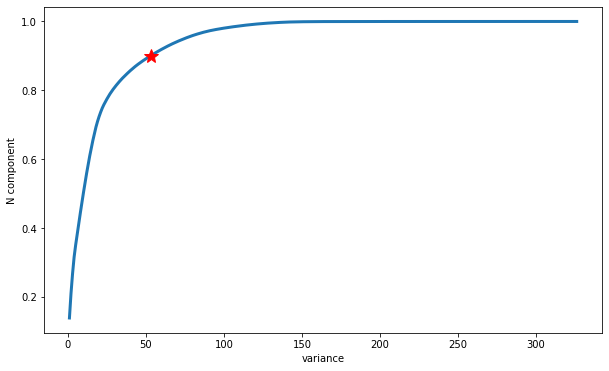

In [27]:
pca = PCA(n_components=X.shape[1])
pca.fit_transform(X)
cumsum = pca.explained_variance_ratio_.cumsum()
d = np.where(cumsum>=0.9)[0][0] + 1
print(f' d = {d}')

plt.figure(figsize=(10,6))
plt.plot(range(1,len(cumsum)+1), cumsum, linewidth=3)
plt.plot(d, cumsum[d-1],'r*',markersize=15)
plt.xlabel("variance")
plt.ylabel("N component")
plt.show()

In [29]:
pca = PCA(n_components=53)
X_pca = pca.fit_transform(X)

In [31]:
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X_pca):
    X_train = X_pca[train_ix,:]
    X_test  = X_pca[test_ix,:] 
    y_train = Y[train_ix]
    y_test  = Y[test_ix]
    clf = svm.SVC(kernel="poly", class_weight=class_weight)    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred, average='macro')
    print(f1)
    scores.append(f1)    

0.6772976301869422
0.6727235332032242
0.6634725810103412


# Deep learning model

In [ ]:
print(X_train.shape[1])
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

326
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               83712     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)              

In [ ]:
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=5, restore_best_weights=True),
                 ]
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)


model.compile(loss = "categorical_crossentropy",                
                optimizer=optimizer,
                metrics = ["acc"])                
BATCH_SIZE = 32
EPOCHS = 100
history = model.fit(X_train,
                    y_train,
                    class_weight=class_weight,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1) 

json.dump(str(history.history), open(f"./history.pkl", "w"))
model.save(f'./Model.h5')

Epoch 1/100
3351/3351 [==============================] - 14s 4ms/step - loss: 1.2125 - acc: 0.6513 - val_loss: 0.5746 - val_acc: 0.7351
Epoch 2/100
3351/3351 [==============================] - 13s 4ms/step - loss: 0.9153 - acc: 0.7759 - val_loss: 0.4803 - val_acc: 0.7973
Epoch 3/100
3351/3351 [==============================] - 13s 4ms/step - loss: 0.8108 - acc: 0.8164 - val_loss: 0.4135 - val_acc: 0.8319
Epoch 4/100
3351/3351 [==============================] - 12s 4ms/step - loss: 0.7507 - acc: 0.8220 - val_loss: 0.3280 - val_acc: 0.8594
Epoch 5/100
3351/3351 [==============================] - 12s 4ms/step - loss: 0.6623 - acc: 0.8430 - val_loss: 0.2859 - val_acc: 0.8468
Epoch 6/100
3351/3351 [==============================] - 13s 4ms/step - loss: 0.6372 - acc: 0.8408 - val_loss: 0.5059 - val_acc: 0.8253
Epoch 7/100
3351/3351 [==============================] - 13s 4ms/step - loss: 0.5909 - acc: 0.8654 - val_loss: 0.2332 - val_acc: 0.8975
Epoch 8/100
3351/3351 [=========================

# O.sativa

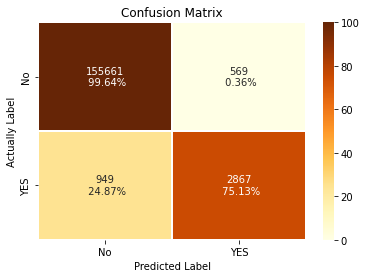

number of unique hit: 19793
total mir: 361
found mir : 258
fount to all : 71.47%
fp: 332
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    156230
           1       0.83      0.75      0.79      3816

    accuracy                           0.99    160046
   macro avg       0.91      0.87      0.89    160046
weighted avg       0.99      0.99      0.99    160046



In [ ]:
plant = 'O.sativa'
y_true = np.argmax(data[plant]['target'], axis=1)
#y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
y_pred =  clf.predict(data[plant]['feature'])
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# A.thaliana

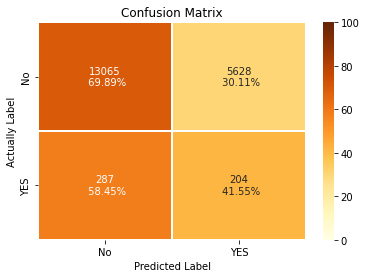

number of unique hit: 3349
total mir: 90
found mir : 50
fount to all : 55.56%
fp: 1231
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     18693
           1       0.03      0.42      0.06       491

    accuracy                           0.69     19184
   macro avg       0.51      0.56      0.44     19184
weighted avg       0.95      0.69      0.80     19184



In [33]:
_X = pca.fit_transform(data[plant]['feature'])
plant = 'A.thaliana'
y_true = np.argmax(data[plant]['target'], axis=1)
#y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
y_pred = clf.predict(_X)
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# C.Sinensis

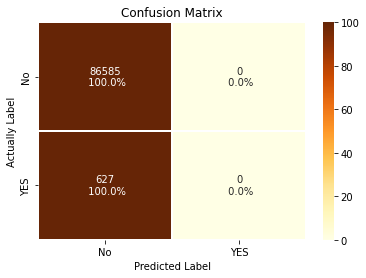

number of unique hit: 6419
total mir: 86
found mir : 0
fount to all : 0.0%
fp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     86585
           1       0.00      0.00      0.00       627

    accuracy                           0.99     87212
   macro avg       0.50      0.50      0.50     87212
weighted avg       0.99      0.99      0.99     87212



In [ ]:
plant = 'C.Sinensis'
y_true = np.argmax(data[plant]['target'], axis=1)
#y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
y_pred = clf.predict(data[plant]['feature'])
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# Z.mays

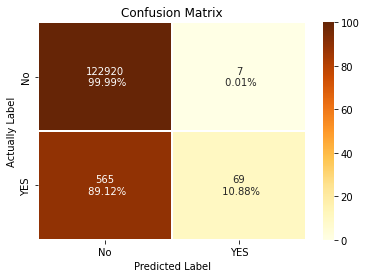

number of unique hit: 9849
total mir: 84
found mir : 10
fount to all : 11.9%
fp: 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122927
           1       0.91      0.11      0.19       634

    accuracy                           1.00    123561
   macro avg       0.95      0.55      0.60    123561
weighted avg       0.99      1.00      0.99    123561



In [ ]:
plant = 'Z.mays'
y_true = np.argmax(data[plant]['target'], axis=1)
#y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
y_pred = clf.predict(data[plant]['feature'])
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))